In [1]:
import enum
from abc import ABCMeta, abstractmethod, abstractproperty

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

# Bayesian bandits

Let us explore a simple task of multi-armed bandits with Bernoulli distributions and several strategies for it.

Bandits have $K$ actions. An action leads to a reward $r=1$ with a probability $0 \le \theta_k \le 1$ unknown to an agent but fixed over time. The agent goal is to minimize total suboptimality over $T$ actions:

$$\rho = T\theta^* - \sum_{t=1}^T r_t,$$

and $\theta^* = \max_k\{\theta_k\}$.

**Real-life example** - clinical trials: we have $k$ drug types and $T$ patients. After some drug is taken a patient is cured with a probability $\theta_k$. The goal is to find an optimal drug. The survey on clinical trials - https://arxiv.org/pdf/1507.08025.pdf.

### Hometask

The task is complementary for the reinforcement learning task, the maximum is 10 points for both.

Implement all the unimplemented agents:

1. [1 балл] $\varepsilon$-greedy
2. [1 балл] UCB
3. [1 балл] Thompson sampling
4. [2 балла] Custom strategy
5. [2 балла] $\varepsilon$-greedy для riverflow
6. [3 балла] PSRL agent для riverflow

In [2]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.random.random() > self._probs[action]:
            return 0.0
        return 1.0

    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)

    def step(self):
        """ Used in nonstationary version
        """
        pass

    def reset(self):
        """ Used in nonstationary version
        """

In [3]:
class AbstractAgent(metaclass=ABCMeta):   
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):    
    def get_action(self):
        return np.random.randint(0, len(self._successes))

### Epsilon-greedy agent

> **for** $t = 1,2,...$ **do**

>> **for** $k = 1,...,K$ **do**

>>> $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

>> **end for** 

>> $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \varepsilon$ or random action with probability $\varepsilon$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

Implement the algorithm described:

In [4]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon = 0.01):
        self._epsilon = epsilon
        
    def init_actions(self, n_actions):
        self._a = np.ones(n_actions) * 1e-5
        self._b = np.ones(n_actions) * 1e-5
        self._n_actions = n_actions

    def get_action(self):
        if np.random.random() < self._epsilon:
            return np.random.randint(self._n_actions)
        thetas = self._a / (self._a + self._b) 
        return np.argmax(thetas)

    def update(self, action, reward):
        self._a[action] += reward
        self._b[action] += (1 - reward)   
        
    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon) 

### UCB agent
Epsilon-greedy strategy has no preferences on the random choice stage. Probably it is better to choose the actions we are not sure enough in, but having a potential to become optimal in the future. We could create the measure for both optimality and uncertainty in the same time.

One of possible sollutions for that is UCB1 algorithm:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$

>> **end for** 

>> $x_t \leftarrow argmax_{k}w$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

Other solutions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf.

In [5]:
class UCBAgent(AbstractAgent):
    def __init__(self):
        pass
        
    def init_actions(self, n_actions):
        self._a = np.ones(n_actions) * 1e-5
        self._b = np.ones(n_actions) * 1e-5
        self._t = 1

    def get_action(self):
        doubleus = self._a / (self._a + self._b) + np.sqrt(2 * np.log(self._t) / (self._a + self._b))
        return np.argmax(doubleus)

    def update(self, action, reward):
        self._a[action] += reward
        self._b[action] += (1 - reward)
        self._t += 1

### Thompson sampling

UCB1 algorithm does not consider the rewards distribution. If it is known, we can improve it with Thompson sampling.

We believe that $\theta_k$ are independent and indentically distributed. As a prior distribution for them we will use beta-distribution with parameters $\alpha=(\alpha_1, \dots, \alpha_k)$ and $\beta=(\beta_1, \dots, \beta_k)$. Thus for each parameter $\theta_k$ an apriori probability function looks like
$$
p(\theta_k) =
\frac{\Gamma(\alpha_k + \beta_k)}{\Gamma(\alpha_k) + \Gamma(\beta_k)}
\theta_k^{\alpha_k - 1}(1 - \theta_k)^{\beta_k - 1}
$$
After receiving new evidence the distribution is updated following the Bayes rule.

Beta distribution is comfortable to work with because of conjugation - actions aposterior distribution will be Beta too so we can easily update them:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> Sample $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

>> **end for** 

>> $x_t \leftarrow argmax_{k}\hat\theta$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**
 
Hometask: https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf.

In [6]:
class ThompsonSamplingAgent(AbstractAgent):
    def __init__(self):
        pass
        
    def init_actions(self, n_actions):
        self._a = np.ones(n_actions) * 1e-5
        self._b = np.ones(n_actions) * 1e-5

    def get_action(self):
        thetas = np.random.beta(self._a, self._b)
        return np.argmax(thetas)

    def update(self, action, reward):
        self._a[action] += reward
        self._b[action] += (1 - reward)

In [7]:
def plot_regret(env, agents, n_steps=5000, n_trials=50):
    scores = {
        agent.name : [0.0 for step in range(n_steps)] for agent in agents
    }

    for trial in range(n_trials):
        env.reset()
        
        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()
            
            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward
                
            env.step()  # change bandit's state if it is unstationary

    plt.figure(figsize=(17, 8))
    for agent in agents:
        plt.plot(np.cumsum(scores[agent.name]) / n_trials)

    plt.legend([agent.name for agent in agents])
    
    plt.ylabel("regret")
    plt.xlabel("steps")
    
    plt.show()

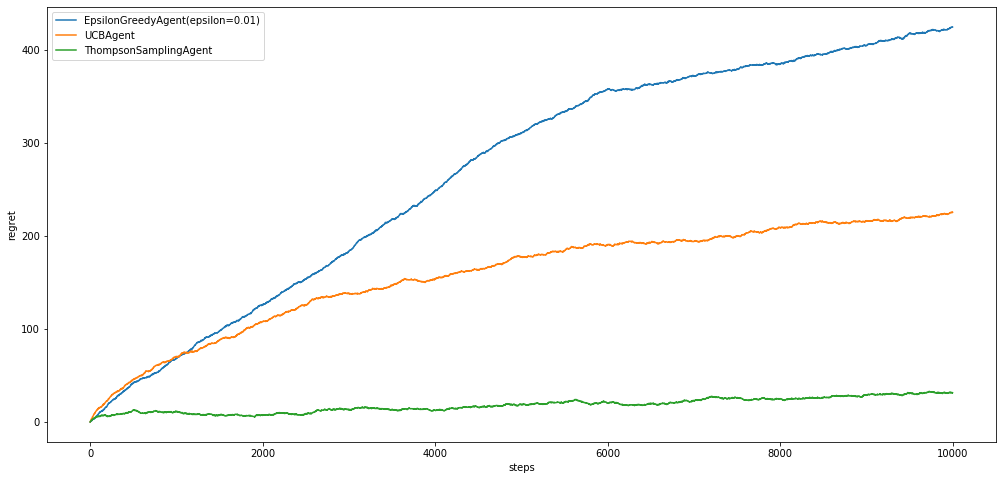

In [8]:
# Uncomment agents
agents = [
     EpsilonGreedyAgent(),
     UCBAgent(),
     ThompsonSamplingAgent()
]

plot_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)

# Non-stationary bandits

But what if the probabilities change over time? For example

In [9]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=0.01):
        """
        Idea from https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)
        
        self._gamma = gamma
        
        self._successes = None
        self._failures = None
        self._steps = 0
        
        self.reset()
        
    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.0
        self._failures = np.zeros(self.action_count) + 1.0
        self._steps = 0
    
    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)
        
    def _step(self, action, reward): 
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probs = np.random.beta(self._successes, self._failures)

Letus look at the reward probabilities changing over time:

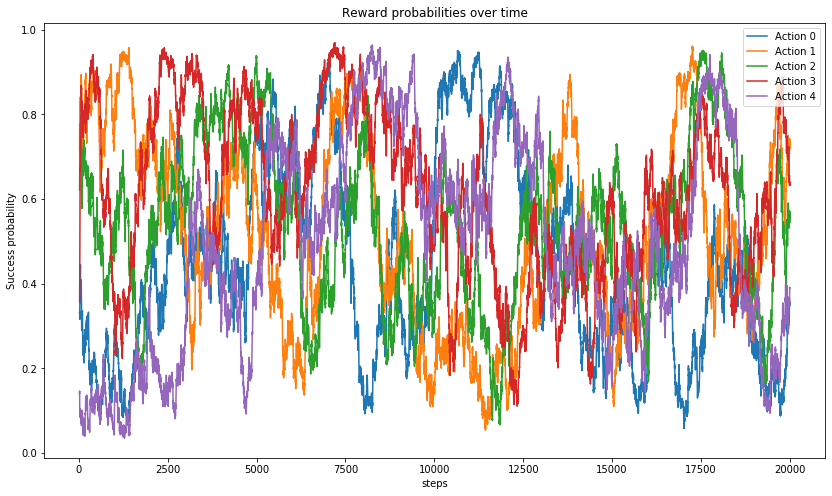

In [10]:
drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(14, 8))
plt.plot(pd.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("steps")
plt.ylabel("Success probability")
plt.title("Reward probabilities over time")
plt.legend(["Action {}".format(i) for i in range(drifting_env.action_count)])
plt.show()

**Task** - create an agent that will work better then any of the stationary algorithms above.

In [11]:
class YourAgent(AbstractAgent):
    def __init__(self, coef=0.995):
        self._coef = coef
        
    def init_actions(self, n_actions):
        self._a = np.ones(n_actions) * 1e-5
        self._b = np.ones(n_actions) * 1e-5
        self._t = 1
        
    def get_action(self):
        doubleus = (self._a / (self._a + self._b) + np.sqrt(2 * np.log(self._t) / (self._a + self._b)))
        return np.argmax(doubleus)

    def update(self, action, reward):
        self._a[action] = self._coef * self._a[action] + reward
        self._b[action] = self._coef * self._b[action] + (1 - reward)
        self._t = self._coef * self._t + 1

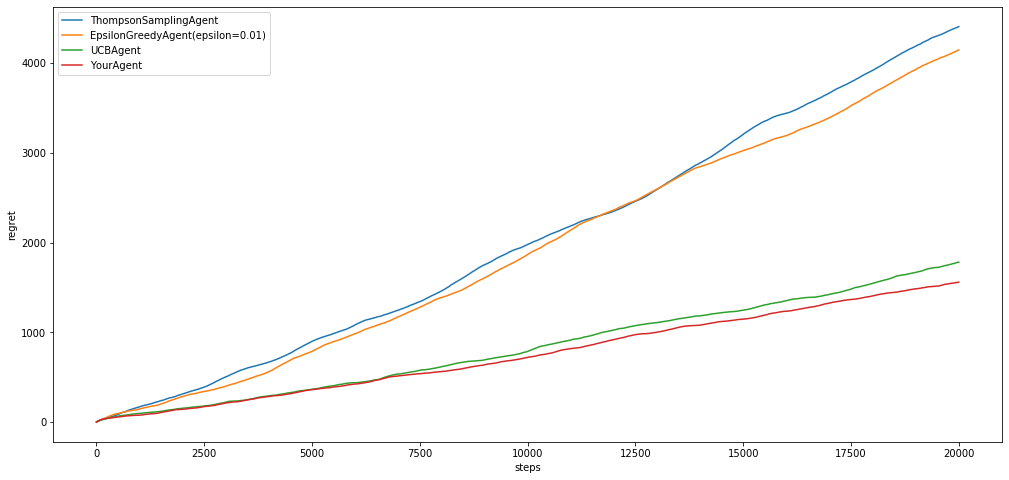

In [12]:
drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
    YourAgent()
]

plot_regret(DriftingBandit(), drifting_agents, n_steps=20000, n_trials=10)

## Exploration в MPDP

The next task, "river flow", illustrates the importance of exploration with Markov decision-making processes example.

<img src="river_swim.png">

Illustration from https://arxiv.org/abs/1306.0940

Both rewards and transitions are unknown to the agent.

The optimal strategy is to go right against the flow, but the easiest one is to keep going left and get small rewards each time.

In [13]:
class RiverSwimEnv:
    LEFT_REWARD = 5.0 / 1000
    RIGHT_REWARD = 1.0
    
    def __init__(self, intermediate_states_count=4, max_steps=16):
        self._max_steps = max_steps
        self._current_state = None
        self._steps = None
        self._interm_states = intermediate_states_count
        self.reset()
        
    def reset(self):
        self._steps = 0
        self._current_state = 1
        return self._current_state, 0.0, False
        
    @property
    def n_actions(self):
        return 2
    
    @property
    def n_states(self):
        return 2 + self._interm_states
    
    def _get_transition_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0, 1.0, 0]
            else:
                return [1.0, 0, 0]
            
        elif action == 1:
            if self._current_state == 0:
                return [0, .4, .6]
            if self._current_state == self.n_states - 1:
                return [.4, .6, 0]
            else:
                return [.05, .6, .35]
        else:
            raise RuntumeError("Unknown action {}. Max action is {}".format(action, self.n_actions))

    def step(self, action):
        """
        :param action:
        :type action: int
        :return: observation, reward, is_done
        :rtype: (int, float, bool)
        """
        reward = 0.0
        
        if self._steps >= self._max_steps:
            return self._current_state, reward, True
        
        transition = np.random.choice(range(3), p=self._get_transition_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1
        
        if self._current_state == 0:
            reward = self.LEFT_REWARD
        elif self._current_state == self.n_states - 1:
            reward = self.RIGHT_REWARD
        
        self._steps += 1
        return self._current_state, reward, False

Lets impement Q-learning agent with an $\varepsilon$-greedy strategy and look at its performance.

In [14]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=0.2, gamma=0.95, epsilon=0.1):
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n_states, n_actions))
        self._lr = lr

    def get_action(self, state):
        if np.random.random() < self._epsilon:
            return np.random.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])
    
    def get_q_matrix(self):
        """ Used for policy visualization
        """
        
        return self._q_matrix
        
    def start_episode(self):
        """ Used in PSRL agent
        """
        pass

    def update(self, state, action, reward, next_state):
        max_val = self._q_matrix[next_state].max()
        self._q_matrix[state][action] += self._lr * \
                                        (reward + self._gamma * max_val - self._q_matrix[state][action])

In [15]:
def train_mdp_agent(agent, env, n_episodes):
    episode_rewards = []
    
    for ep in range(n_episodes):
        state, ep_reward, is_done = env.reset()
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)
            
            next_state, reward, is_done = env.step(action)
            agent.update(state, action, reward, next_state)
            
            state = next_state
            ep_reward += reward
            
        episode_rewards.append(ep_reward)
    return episode_rewards

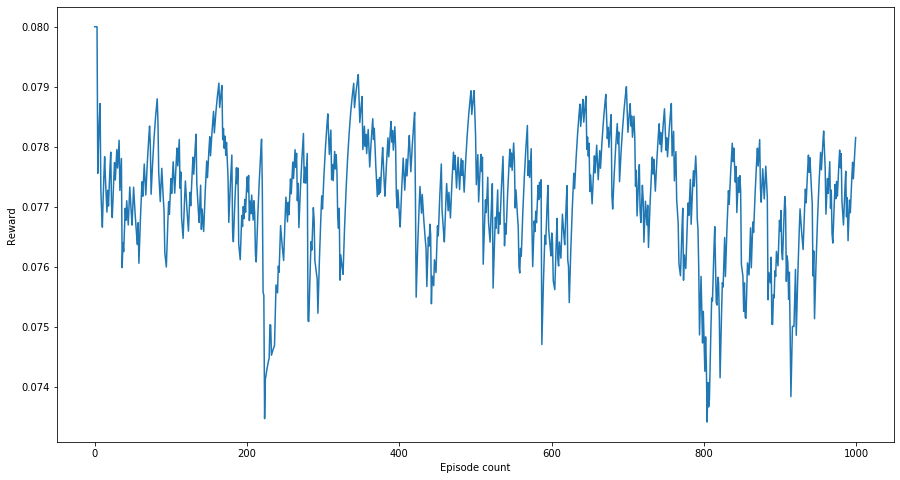

In [16]:
env = RiverSwimEnv()
agent = QLearningAgent(env.n_states, env.n_actions)
rews = train_mdp_agent(agent, env, 1000)
plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(rews)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

Implement policy decisions visualization:

In [17]:
def plot_policy(agent):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.matshow(agent.get_q_matrix().T)
    ax.set_yticklabels(['', 'left', 'right'])
    plt.xlabel("State")
    plt.ylabel("Action")
    plt.title("Values of state-action pairs")
    plt.show()

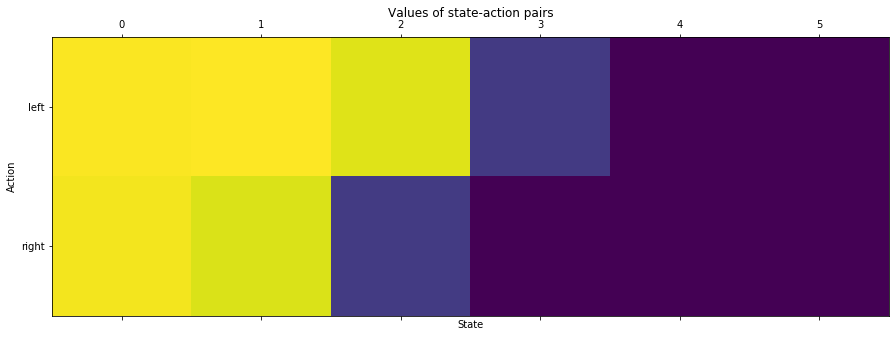

In [18]:
plot_policy(agent)

We can see that the agent uses non-optimalstrategy and keeps going left, not knowing the better option.

## Posterior sampling RL

Let us implement Thompson Sampling for MPDP!

The algorithm:

>**for** episode $k = 1,2,...$ **do**
>> sample $M_k \sim f(\bullet\ |\ H_k)$

>> compute policy $\mu_k$ for $M_k$

>> **for** time $t = 1, 2,...$ **do**

>>> take action  $a_t$ from $\mu_k$ 

>>> observe $r_t$ and $s_{t+1}$
>>> update $H_k$

>> **end for**

>**end for**

$M_k$ is modeled as two matrices: transitions and rewards. Transition matrix is sampled from Dirichlet distribution while reward matrix is sampled from Gamma-normal distribution.

The distibutions are updated following the bayes rule (see https://en.wikipedia.org/wiki/Conjugate_prior for continous distributions).

Follow-up reading - https://arxiv.org/abs/1306.0940.

In [19]:
def bellman(val, trans, rewards):
    q = np.zeros(rewards.shape)
    for state in range(rewards.shape[0]):
        for action in range(rewards.shape[1]):
            q[state][action] = rewards[state][action] + val.dot(trans[state,:,action])
    return q.max(axis=1)

In [20]:
def sample_normal_gamma(mu, lmbd, alpha, beta):
    """ https://en.wikipedia.org/wiki/Normal-gamma_distribution
    """
    tau = np.random.gamma(alpha, beta)
    mu = np.random.normal(mu , 1.0 / np.sqrt(lmbd * tau))
    return mu, tau

class PsrlAgent:
    def __init__(self, n_states, n_actions, horizon=10):
        self._n_states = n_states
        self._n_actions = n_actions
        self._horizon = horizon
        
        # params for transition sampling - Dirichlet distribution
        self._transition_counts = np.zeros((n_states, n_states, n_actions)) + 1.0
        
        # params for reward sampling - Normal-gamma distribution
        self._mu_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._state_action_counts = np.zeros((n_states, n_actions)) + 1.0  # lambda
        
        self._alpha_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._beta_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._val = np.zeros(n_states)
        
    def _value_iteration(self, transitions, rewards):
        for _ in range(self._horizon):
            self._val = bellman(self._val, transitions, rewards)
        return self._val
        
    def start_episode(self):
        # sample new  mdp
        self._sampled_transitions = np.apply_along_axis(np.random.dirichlet, 1, self._transition_counts)
        
        sampled_reward_mus, sampled_reward_stds = sample_normal_gamma(
            self._mu_matrix,
            self._state_action_counts,
            self._alpha_matrix,
            self._beta_matrix
        )

        self._sampled_rewards = sampled_reward_mus
        self._current_value_function = self._value_iteration(self._sampled_transitions, self._sampled_rewards)

    def get_action(self, state):
        return np.argmax(self._sampled_rewards[state] + 
                         self._current_value_function.dot(self._sampled_transitions[state]))

    def update(self, state, action, reward, next_state):
        
        mu0 = self._mu_matrix[state][action]
        v = self._state_action_counts[state][action]
        a = self._alpha_matrix[state][action]
        b = self._beta_matrix[state][action]
        
        self._mu_matrix[state][action] = (mu0 * v + reward) / (v + 1)
        self._state_action_counts[state][action] = v + 1
        self._alpha_matrix[state][action] = a + 1/2
        self._beta_matrix[state][action] = b + (v / (v + 1)) * (((reward - mu0) ** 2) / 2)
        
        self._transition_counts[state][next_state][action] += 1
        
    def get_q_matrix(self):
        return self._sampled_rewards + self._current_value_function.dot(self._sampled_transitions)

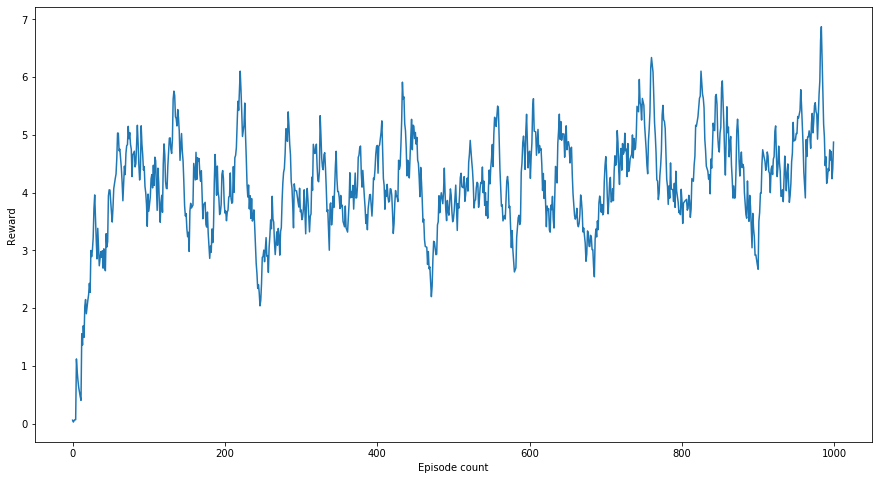

In [21]:
horizon = 20
env = RiverSwimEnv(max_steps=horizon)
agent = PsrlAgent(env.n_states, env.n_actions, horizon=horizon)
rews = train_mdp_agent(agent, env, 1000)

plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame(np.array(rews)).ewm(alpha=.1).mean())

plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

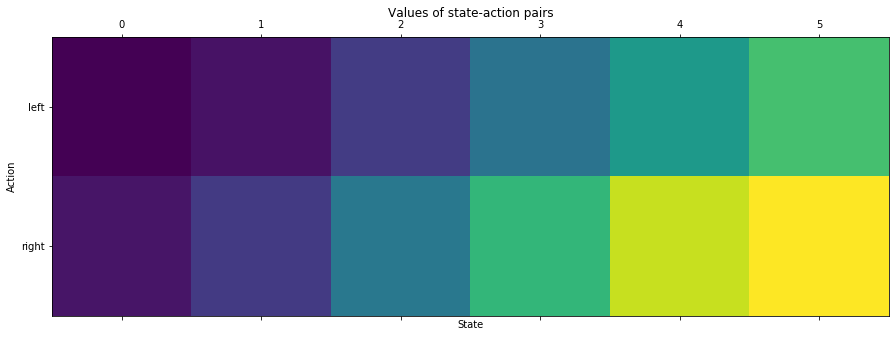

In [22]:
plot_policy(agent)